In [1]:
#Importing relevat libraries
% matplotlib notebook
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Loading reject datasets, doing some data cleaning
reject_1 = pd.read_csv('/Users/ash/Downloads/LoanData/RejectStats_2018Q1.csv')
reject_2 = pd.read_csv('/Users/ash/Downloads/LoanData/RejectStats_2018Q2.csv')
reject = pd.concat((reject_1, reject_2), axis=0)
reject.columns = ['req_amt', 'app_date', 'title', 'risk_score', 'dti', 'zip', 'state', 'emp_length', 'policy']
reject = reject.drop(['app_date', 'risk_score'], axis=1)
reject['approve']= 0
def dumb_data_encoding_correction(x): 
    return float(x.strip('%'))/100
reject['dti'] = reject['dti'].apply(dumb_data_encoding_correction)

In [3]:
#Check for missing data
reject.isnull().sum()

req_amt           0
title             0
dti               0
zip               0
state             0
emp_length    29183
policy            0
approve           0
dtype: int64

In [4]:
reject['emp_length'] = reject['emp_length'].replace(np.nan, reject['emp_length'].mode()[0])
reject.isnull().sum()

req_amt       0
title         0
dti           0
zip           0
state         0
emp_length    0
policy        0
approve       0
dtype: int64

In [5]:
approve_1 = pd.read_csv('/Users/ash/Downloads/LoanData/LoanStats_2018Q1.csv')
approve_2 = pd.read_csv('/Users/ash/Downloads/LoanData/LoanStats_2018Q2.csv')
approve = pd.concat((approve_1, approve_2), axis=0)
approve = approve[['loan_amnt', 'title', 'dti', 'zip_code', 'addr_state', 'emp_length', 'policy_code']]
approve.columns = ['req_amt', 'title', 'dti', 'zip', 'state', 'emp_length', 'policy']
approve['approve'] = 1
def dumb_data_encoding_correction_2(x): 
    return float(x)/100
approve['dti'] = approve['dti'].apply(dumb_data_encoding_correction_2)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
approve.isnull().sum()

req_amt           0
title             0
dti             588
zip               0
state             0
emp_length    19896
policy            0
approve           0
dtype: int64

In [7]:
approve['dti'] = approve['dti'].replace(np.nan, approve['dti'].median())
approve['emp_length'] = approve['emp_length'].replace(np.nan, approve['emp_length'].mode()[0])
approve.isnull().sum()

req_amt       0
title         0
dti           0
zip           0
state         0
emp_length    0
policy        0
approve       0
dtype: int64

In [8]:
loan_2018 = pd.concat((approve, reject), axis=0)
loan_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2335784 entries, 0 to 1048573
Data columns (total 8 columns):
req_amt       float64
title         object
dti           float64
zip           object
state         object
emp_length    object
policy        int64
approve       int64
dtypes: float64(2), int64(2), object(4)
memory usage: 160.4+ MB


<IPython.core.display.Javascript object>


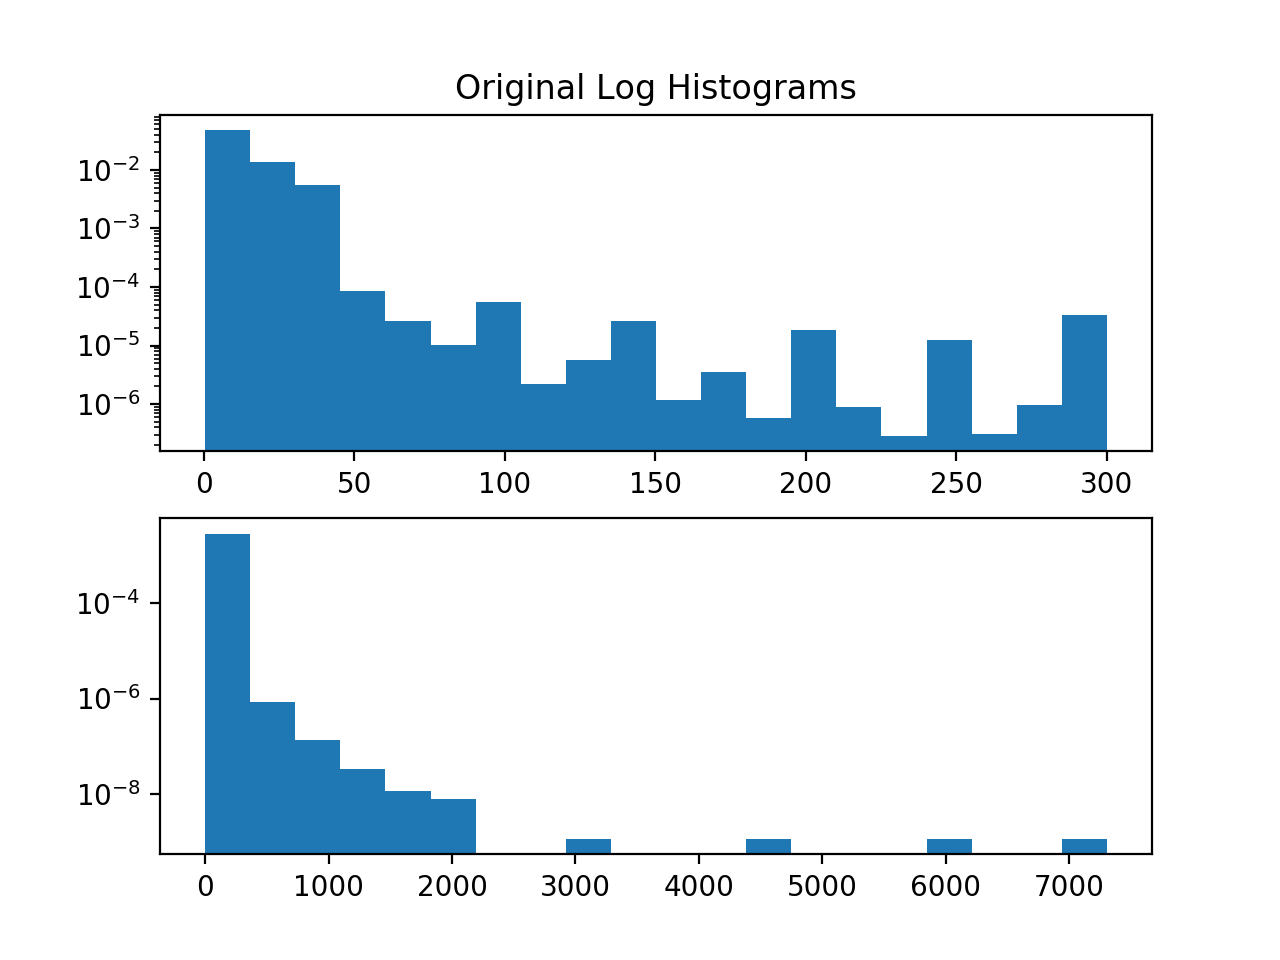

In [9]:
plt.subplot(2,1,1)
plt.hist(np.array(loan_2018['req_amt'])/1000, bins=20, density=True, log=True)
plt.title('Original Log Histograms')
plt.subplot(2,1,2)
plt.hist(np.array(loan_2018['dti']), bins=20, density=True, log=True)
plt.show()

<IPython.core.display.Javascript object>


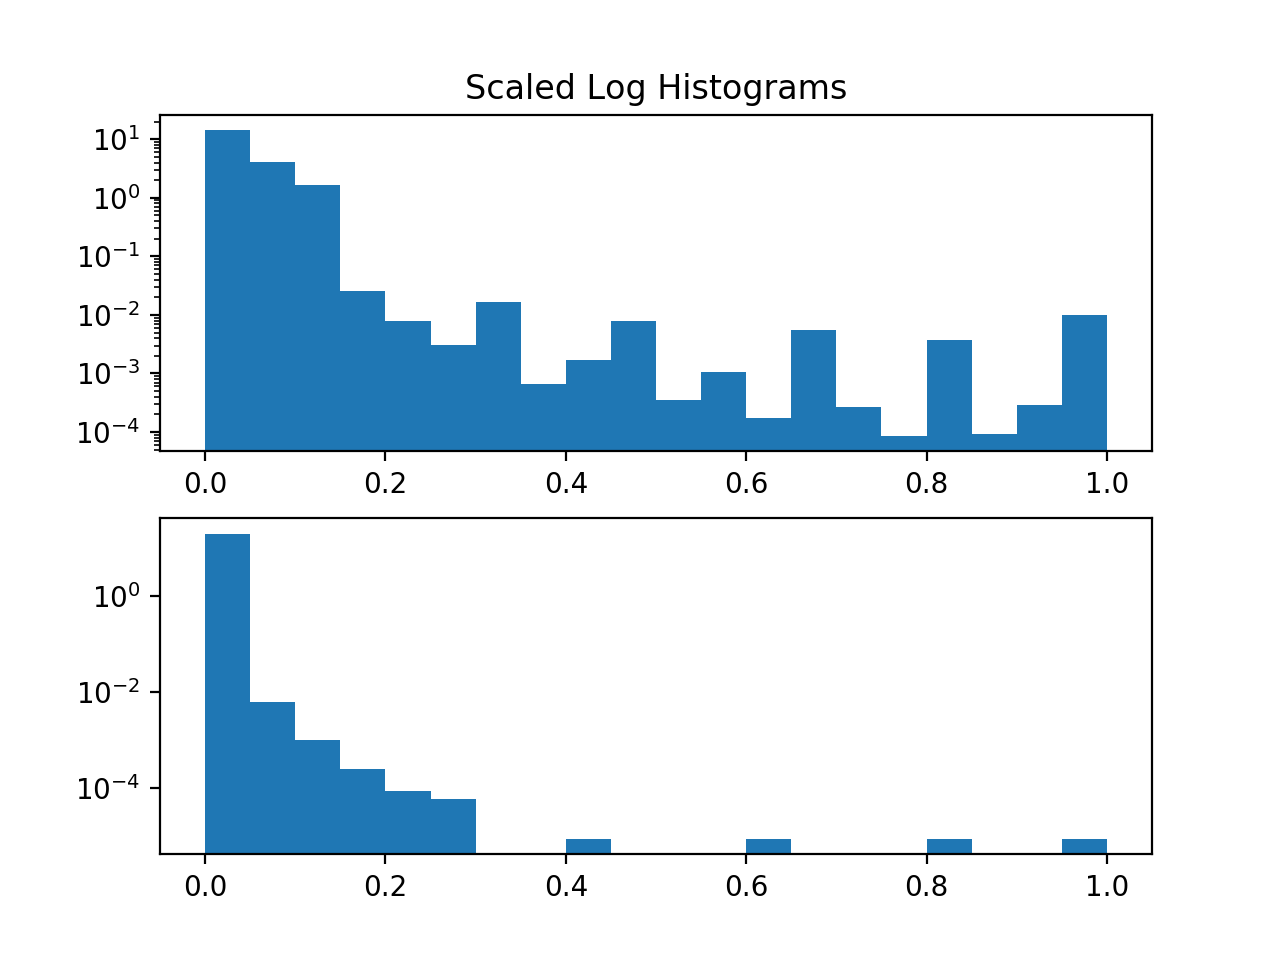

In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

scaler = MinMaxScaler()

loan_2018['dti'] = scaler.fit_transform(np.array(loan_2018['dti']).reshape(-1,1))
loan_2018['req_amt'] = scaler.fit_transform(np.array(loan_2018['req_amt']).reshape(-1,1))

plt.subplot(2,1,1)
plt.hist(np.array(loan_2018['req_amt']), bins=20, density=True, log=True)
plt.title('Scaled Log Histograms')
plt.subplot(2,1,2)
plt.hist(np.array(loan_2018['dti']), bins=20, density=True, log=True)
plt.show()

In [13]:
title = pd.get_dummies(loan_2018['title'], prefix='ti')
state = pd.get_dummies(loan_2018['state'], prefix='st')
employ = pd.get_dummies(loan_2018['emp_length'], prefix='em')
# policy = pd.get_dummies(loan_2018['policy'], prefix='po')

loan_2018 = loan_2018.drop(['title', 'state', 'emp_length', 'policy'], axis=1) 
loan_2018 = pd.concat((loan_2018, title, state, employ), axis=1)

In [14]:
loan_2018 = loan_2018.drop(['zip'], axis=1) 
# loan_2018.to_csv('/Users/Ash/Downloads/LoanData/loan_2018_0zip.csv')

In [105]:
from sklearn.model_selection import train_test_split

Train, Test, _, _ = train_test_split(loan_2018, loan_2018, test_size=0.2, random_state=42)

In [107]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

'''
Baseline Classification Model
'''

#Using LogisticRegression
classifier = LogisticRegression(penalty='l2', solver='lbfgs')

#Using approval status as label
clf_label = Train['approve']
clf_feature = Train.drop(['approve'], axis=1)

#Cross-validation on the training set
acc = cross_val_score(classifier, clf_feature, clf_label, cv=3, scoring='accuracy')
f1 = cross_val_score(classifier, clf_feature, clf_label, cv=3, scoring='f1')
auc = cross_val_score(classifier, clf_feature, clf_label, cv=3, scoring='roc_auc')

print('CV acc mean:', np.mean(acc))
print('CV f1 mean:', np.mean(f1))
print('CV auc mean:', np.mean(auc))

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda/lib/p

CV acc mean: 0.9689772223540913
CV f1 mean: 0.8581259727974723
CV auc mean: 0.9638433457027024


In [108]:
classifier.fit(clf_feature, clf_label)
import pickle

with open('/Users/ash/Downloads/base_classifer.model', 'wb') as f: 
    pickle.dump(classifier, f)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [109]:
'''
Idea 1: A conservative guess for rejected individuals 
'''
#Separating into approve and reject set
approve = Train.loc[Train['approve'] == 1]
reject = Train.loc[Train['approve'] == 0]
print('Number of approve:', approve.shape[0])
print('Number of reject:', reject.shape[0])

Number of approve: 190912
Number of reject: 1677715


In [110]:
#Simple LinearRegression to predict the amount of requested (and approved) for the approve set
approve_label = approve['req_amt']
approve_feature = approve.drop(['req_amt', 'approve'], axis=1)

model_maxfund = LinearRegression() 
mse = cross_val_score(model_maxfund, approve_feature, approve_label,  cv=2, scoring='neg_mean_squared_error')
mae = cross_val_score(model_maxfund, approve_feature, approve_label,  cv=2, scoring='neg_mean_absolute_error')
print('CV MSE Mean:',-np.mean(mse))
print('CV MAE Mean:',-np.mean(mae))

CV MSE Mean: 0.0010976587403326967
CV MAE Mean: 0.027006318289891286


In [111]:
model_maxfund.fit(approve_feature, approve_label)
preds = model_maxfund.predict(approve_feature)
preds = scaler.inverse_transform(preds.reshape(-1,1))
truths = scaler.inverse_transform(np.array(approve_label).reshape(-1,1))
print('MSE in original units:', np.mean((truths-preds)**2))
print('MAE in original units:' ,np.mean(np.abs(truths-preds)))

MSE in original units: 98438644.53607078
MAE in original units: 8087.041402282708


In [112]:
reject_label = reject['req_amt']
reject_feature = reject.drop(['req_amt', 'approve'], axis=1)

reject_maxfund = model_maxfund.predict(reject_feature)
sum(reject_label > reject_maxfund)/reject_label.shape[0]

0.30460000655653674

In [113]:
'''
Idea 2: Probability Thresholding
'''
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty='l2', solver='lbfgs')

proba_label = Train['approve']
proba_feature = Train.drop(['approve'], axis=1)

classifier.fit(proba_feature, proba_label)
probas = classifier.predict_proba(proba_feature)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
maxfund = np.multiply(scaler.inverse_transform(np.array(proba_label).reshape(-1,1)),probas[:,1])

In [115]:
'''
Idea 1: K-Means Clustering
'''
#Using a slice of the data due to computational constraints
mini_train, _, _, _ = train_test_split(Train, Train, train_size=0.2)

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [116]:
from sklearn.cluster import KMeans, MiniBatchKMeans

mini_loan = mini_train['req_amt']
mini_approve = mini_train['approve']
mini_f = mini_train.drop(['req_amt', 'approve'], axis=1)

cluster = KMeans(n_clusters=10)
preds = cluster.fit_predict(mini_f)

In [117]:
mini_train['cluster'] = preds
cluster_median = mini_train.groupby(mini_train['cluster'])['req_amt'].median()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [118]:
l = [] 
for _ in range(mini_train.shape[0]):
    if mini_train.iloc[_,2] == 0: 
        l.append(min(cluster_median[mini_train.iloc[_,-1]],mini_train.iloc[_,0]))
    elif  mini_train.iloc[_,2] == 1:
        l.append(max(cluster_median[mini_train.iloc[_,-1]],mini_train.iloc[_,0]))

In [119]:
mini_train['predicted_max_amt'] = np.array(l)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [120]:
#Training a simple regressor using the clustering groundtruths
mini_label = mini_train['predicted_max_amt']
mini_feature = mini_train.drop(['predicted_max_amt', 'cluster', 'req_amt', 'approve'],axis=1)
reg = LinearRegression()

reg.fit(mini_feature, mini_label)
preds = reg.predict(mini_feature)
preds = scaler.inverse_transform(preds.reshape(-1,1))
truths = scaler.inverse_transform(np.array(mini_label).reshape(-1,1))
print('MSE in original units:', np.mean((truths-preds)**2))
print('MAE in original units:' ,np.mean(np.abs(truths-preds)))

MSE in original units: 15721813.80325526
MAE in original units: 2762.4051739792653


In [ ]:
#classifier

#model_maxfund

#reg

In [121]:
'''
Testing Performance
'''
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score 
test_label = Test['approve']
test_feature = Test.drop(['approve'], axis=1)

test_preds = classifier.predict(test_feature)
print('Test Acc:', accuracy_score(test_label, test_preds))
print('Test F1:', f1_score(test_label, test_preds))
print('Test AUC of ROC:', roc_auc_score(test_label, test_preds))

Test Acc: 0.9690382462426979
Test F1: 0.8586782350412319
Test AUC of ROC: 0.9476424731933075


In [152]:
test_approve = Test.loc[Test['approve'] == 1]
test_reject = Test.loc[Test['approve'] == 0]
print(test_approve.shape)
print(test_reject.shape)

(47724, 79)
(419433, 79)


In [154]:
# Test Idea 1: 
test_reject_1 = test_reject.drop(['approve'], axis=1)
test_reject_feature = test_reject_1.drop(['req_amt'], axis=1)
predict_1 = model_maxfund.predict(test_reject_feature)
# test_reject_1['req_amt'] = predict_1

confirm_1 = classifier.predict(test_reject_1)
print('Total Approved For Predicted Max Fund, Model 1:', sum(confirm_1)/len(confirm_1))

Total Approved For Predicted Max Fund, Model 1: 0.025467714748243463


In [156]:
# Test Idea 2: 
test_reject_2 = test_reject.drop(['approve'], axis=1)
probas = classifier.predict_proba(test_reject_2)
maxfund = np.multiply(probas[:,1], test_reject_2['req_amt'])
test_reject_2['req_amt'] = maxfund

confirm_2 = classifier.predict(test_reject_2)
print('Total Approved For Predicted Max Fund, Model 2:', sum(confirm_2)/len(confirm_2))

Total Approved For Predicted Max Fund, Model 2: 0.025458178064196188


In [148]:
# Test Idea 3: 
test_reject_3 = test_reject.drop(['approve'], axis=1)
test_reject_feature_3 = test_reject_3.drop(['req_amt'], axis=1)
clusters = cluster.predict(test_reject_feature_3)
test_reject_3['cluster'] = clusters

l = [] 
for _ in range(test_reject_3.shape[0]):
    if test_reject_3.iloc[_,2] == 0: 
        l.append(min(cluster_median[test_reject_3.iloc[_,-1]],test_reject_3.iloc[_,0]))
    elif  test_reject_3.iloc[_,2] == 1:
        l.append(max(cluster_median[test_reject_3.iloc[_,-1]],test_reject_3.iloc[_,0]))

test_reject_3['req_amt'] = np.array(l)
test_reject_3 = test_reject_3.drop(['cluster'], axis=1)
confirm_3 = classifier.predict(test_reject_3)

In [149]:
print('Total Approved For Predicted Max Fund, Model 3:', sum(confirm_3)/len(confirm_3))

Total Approved For Predicted Max Fund, Model 3: 0.025259951779652682


<IPython.core.display.Javascript object>


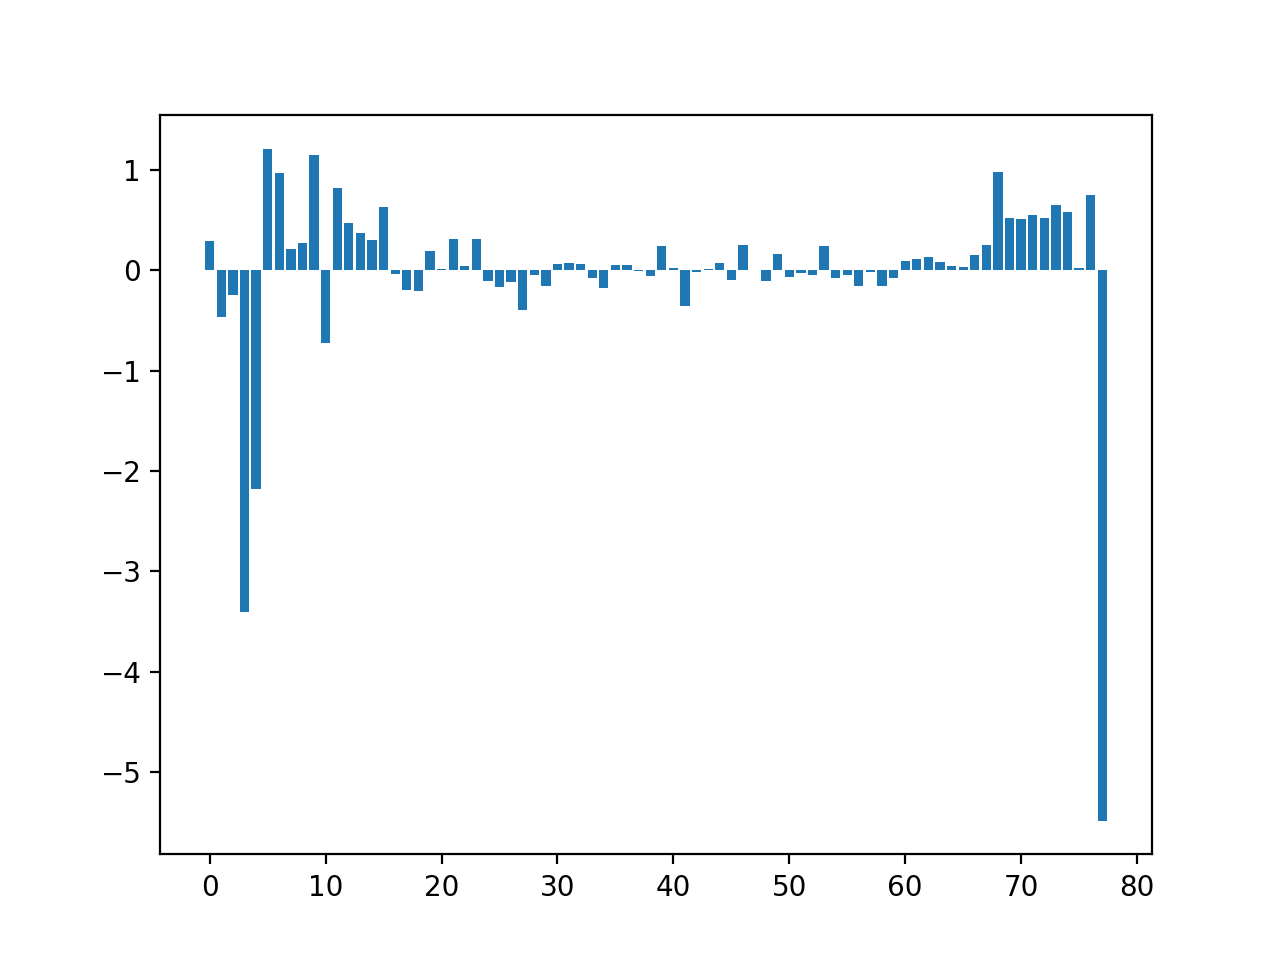

Index(['req_amt', 'dti', 'ti_Business', 'ti_Business Loan', 'ti_Car financing',
       'ti_Credit card refinancing', 'ti_Debt consolidation', 'ti_Green loan',
       'ti_Home buying', 'ti_Home improvement', 'ti_Learning and training',
       'ti_Major purchase', 'ti_Medical expenses', 'ti_Moving and relocation',
       'ti_Other', 'ti_Vacation', 'st_AK', 'st_AL', 'st_AR', 'st_AZ', 'st_CA',
       'st_CO', 'st_CT', 'st_DC', 'st_DE', 'st_FL', 'st_GA', 'st_HI', 'st_IA',
       'st_ID', 'st_IL', 'st_IN', 'st_KS', 'st_KY', 'st_LA', 'st_MA', 'st_MD',
       'st_ME', 'st_MI', 'st_MN', 'st_MO', 'st_MS', 'st_MT', 'st_NC', 'st_ND',
       'st_NE', 'st_NH', 'st_NJ', 'st_NM', 'st_NV', 'st_NY', 'st_OH', 'st_OK',
       'st_OR', 'st_PA', 'st_RI', 'st_SC', 'st_SD', 'st_TN', 'st_TX', 'st_UT',
       'st_VA', 'st_VT', 'st_WA', 'st_WI', 'st_WV', 'st_WY', 'em_1 year',
       'em_10+ years', 'em_2 years', 'em_3 years', 'em_4 years', 'em_5 years',
       'em_6 years', 'em_7 years', 'em_8 years', 'em_9 year

In [168]:
Train_aa = Train.drop(['approve'], axis=1)

plt.bar([_ for _ in range(78)],classifier.coef_[0],)
plt.show()
print(Train_aa.columns)